In [1]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn import datasets

import sys
!{sys.executable} -m pip install PyAthena
from pyathena import connect
import pandas as pd
from pyathena.async_cursor import AsyncCursor

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly

import boto3
import json

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Matplotlib is building the font cache; this may take a moment.


In [2]:
def q2df(q):
    cursor = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2', cursor_class=AsyncCursor).cursor(max_workers=2)
    query_id, future = cursor.execute(q)
    print (query_id, future)
#i=0
#for row in cursor:
#    if i==0:
#        print(row)
#    i+=1
#pd.options.display.float_format = '{:,.4f}'.format
#df = pd.read_sql(q, conn)
#df
    result_set = future.result()
    print(result_set.state)
#    print(result_set.state_change_reason)
#    print(result_set.completion_date_time)
#    print(result_set.submission_date_time)
    print('Data Scanned Bytes:', result_set.data_scanned_in_bytes)
#    print(result_set.engine_execution_time_in_millis)
#    print(result_set.query_queue_time_in_millis)
    print('Total Execution Time (ms):', result_set.total_execution_time_in_millis)
#    print(result_set.query_planning_time_in_millis)
#    print(result_set.service_processing_time_in_millis)
    print('Output location:', result_set.output_location)
    print(result_set.description)


    s3_client = boto3.client('s3')

    obj=result_set.output_location[result_set.output_location.rfind('/')+1:]
    print(obj)

    s3_client.download_file('esdis-ems-athena', obj, 'myOut.csv')

    df=pd.read_csv('myOut.csv')  
    return df

In [5]:
conn = connect(s3_staging_dir='s3://esdis-ems-athena', region_name='us-west-2')
cursor=conn.cursor()

In [6]:
database={}
with open('merra2_database.json', 'r') as f:
  database=json.load(f)
table='merra2_2d_monthly'
print (json.dumps(database, indent=1))
for v in database[table]:
    print (v, '--->', database[table]['variables'][v]['long_name'] + ' (units:' + database[table]['variables'][v]['units'] + ')' )


{
 "merra2_2d_monthly": {
  "products": {
   "M2IMNXGAS": "MERRA2 inst3_2d_gas_Nx: 2d,3-Hourly,Instantaneous,Single-Level,Assimilation,Aerosol Optical Depth Analysis Monthly Mean",
   "M2TMNXAER": "MERRA2 tavg1_2d_aer_Nx: 2d,1-Hourly,Time-averaged,Single-Level,Assimilation,Aerosol Diagnostics Monthly Mean",
   "M2TMNXFLX": "MERRA2 tavg1_2d_flx_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Surface Flux Diagnostics Monthly Mean",
   "M2TMNXOCN": "MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Ocean Surface Diagnostics Monthly Mean",
   "M2TMNXSLV": "MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics Monthly Mean",
   "M2TMNXADG": "MERRA2 tavg1_2d_adg_Nx: 2d,3-Hourly,Time-averaged,Single-Level,Assimilation,Aerosol Diagnostics (extended) Monthly Mean",
   "M2TMNXCHM": "MERRA2 tavg1_2d_chm_Nx: 2d,3-Hourly,Time-Averaged,Single-Level,Assimilation,Carbon Monoxide and Ozone Diagnostics Monthly Mean",
   "M2

KeyError: 'products'

In [7]:
for v in sorted(database[table]['variables']):
    print (v, '--->', database[table]['variables'][v]['long_name'] + ' (units:' + database[table]['variables'][v]['units'] + ')' )


ALBEDO ---> surface_albedo (units:1)
ALBNIRDF ---> surface_albedo_for_near_infrared_diffuse (units:1)
ALBNIRDR ---> surface_albedo_for_near_infrared_beam (units:1)
ALBVISDF ---> surface_albedo_for_visible_diffuse (units:1)
ALBVISDR ---> surface_albedo_for_visible_beam (units:1)
AODANA ---> Aerosol Optical Depth Analysis (units:1)
AODINC ---> Aerosol Optical Depth Analysis Increment (units:1)
BASEFLOW ---> baseflow_flux (units:kg m-2 s-1)
BCANGSTR ---> Black Carbon Angstrom parameter [470-870 nm] (units:1)
BCCMASS ---> Black Carbon Column Mass Density (units:kg m-2)
BCDP001 ---> Black Carbon Dry Deposition Bin 001 (units:kg m-2 s-1)
BCDP002 ---> Black Carbon Dry Deposition Bin 002 (units:kg m-2 s-1)
BCEM001 ---> Black Carbon Emission Bin 001 (units:kg m-2 s-1)
BCEM002 ---> Black Carbon Emission Bin 002 (units:kg m-2 s-1)
BCEMAN ---> Black Carbon Anthropogenic Emissions (units:kg m-2 s-1)
BCEMBB ---> Black Carbon Biomass Burning Emissions (units:kg m-2 s-1)
BCEMBF ---> Black Carbon Biofu

In [30]:
q="""
select
 time,
 avg(TS) avg_ts_global,
 avg( case when lat >= 66.6 then TS else NULL end ) avg_ts_artic,
-- avg(TSKINWTR) TSKINWTR,
-- avg(T2M) T2M,
-- avg(T10M) T10M,
 avg(T250) avg_t250_global,
  avg( case when lat >= 66.6 then T250 else NULL end ) avg_t250_artic
from
 sci.merra2_2d_monthly
group by
 1 
order by
 1
"""
df = q2df(q)

88aa5099-41e3-4944-b4c6-f8cd5478efe5 <Future at 0x7fcdeede0fd0 state=running>
SUCCEEDED
Data Scanned Bytes: 12164503381
Total Execution Time (ms): 10786
Output location: s3://esdis-ems-athena/88aa5099-41e3-4944-b4c6-f8cd5478efe5.csv
[('time', 'timestamp', None, None, 3, 0, 'UNKNOWN'), ('avg_ts_global', 'float', None, None, 17, 0, 'UNKNOWN'), ('avg_ts_artic', 'float', None, None, 17, 0, 'UNKNOWN'), ('avg_t250_global', 'float', None, None, 17, 0, 'UNKNOWN'), ('avg_t250_artic', 'float', None, None, 17, 0, 'UNKNOWN')]
88aa5099-41e3-4944-b4c6-f8cd5478efe5.csv


In [31]:
print (df)

                        time  avg_ts_global  avg_ts_artic  avg_t250_global  \
0    1980-01-01 00:29:52.000      277.31720     251.01760        223.44550   
1    1980-02-01 00:29:52.000      276.87137     250.66455        223.94225   
2    1980-03-01 00:29:52.000      276.66418     252.22970        223.88364   
3    1980-04-01 00:29:52.000      277.67477     256.69907        224.09767   
4    1980-05-01 00:29:52.000      279.45590     266.45914        223.79564   
..                       ...            ...           ...              ...   
499  2021-08-01 00:29:52.000      280.77720     274.44130        223.14633   
500  2021-09-01 00:29:52.000      279.97046     269.79758        222.36082   
501  2021-10-01 00:29:52.000      278.98718     263.71330        222.16985   
502  2021-11-01 00:29:52.000      278.33240     256.36163        221.52505   
503  2021-12-01 00:29:52.000      278.05090     252.88460        222.35835   

     avg_t250_artic  
0         210.31194  
1         211.43910

In [32]:
#for i,r in df.iterrows():
    #print (i, r['time'], r['prectot_sum_local'], r['prectot_sum_global'])    
    #print (i, r)

In [33]:
import plotly.express as px
fig = px.line(df, x='time', y=df.columns, title='Merra2 Monthly 1980-2021, Global versus Regional Trends, Selected Variables')
fig.show()
fig.write_html("MERRA2_time_series" + ".html")

In [34]:
q="""
select
-- LWTUP,
 LWGEM,
 TS
from
 sci.merra2_2d_monthly
where
 Month(time) = 6
 and lat between -30 and 30
"""
#df = pd.read_sql(q, conn)
df=q2df(q)

ac0acfb8-4949-4bec-bda5-b2d6a3fc9b30 <Future at 0x7fcdf41a4978 state=running>
SUCCEEDED
Data Scanned Bytes: 131936012
Total Execution Time (ms): 9712
Output location: s3://esdis-ems-athena/ac0acfb8-4949-4bec-bda5-b2d6a3fc9b30.csv
[('LWGEM', 'float', None, None, 17, 0, 'UNKNOWN'), ('TS', 'float', None, None, 17, 0, 'UNKNOWN')]
ac0acfb8-4949-4bec-bda5-b2d6a3fc9b30.csv


In [35]:
#print (df)
#x=np.dstack((df.lon, df.lat, df.m_month, df.m_week, df.LWGEM, df.LWTUP, df.PRECTOT, df.TS))
#x=np.dstack((df.LWTUP, df.PRECTOT, df.TS))
x=np.dstack((df.LWGEM, df.TS))

In [36]:
print (x.shape)

(1, 2927232, 2)


In [37]:
kmeans=KMeans(n_clusters=6)

In [38]:
kmeans.fit(x[0])

KMeans(n_clusters=6)

In [39]:
print (kmeans.cluster_centers_)
print (kmeans.labels_)
#print (x[0][:,[0]])

[[467.31612474 302.23891617]
 [412.51636774 292.90027207]
 [435.14498151 296.68735532]
 [366.88527789 285.440224  ]
 [496.28888206 309.34994404]
 [452.47370285 299.66775321]]
[2 0 5 ... 2 0 0]


In [ ]:
plt.figure(figsize=(5,6))
plt.scatter(x[0][:,[0]], x[0][:,[1]],c=kmeans.labels_)
plt.xlabel("LWGEM")
plt.ylabel("TS")
plt.show()
#plt.scatter(x[0][:,[0]], x[0][:,[2]],c=kmeans.labels_)
#plt.xlabel("LWTUP")
#plt.ylabel("TS")
#plt.show()
#plt.scatter(x[0][:,[1]], x[0][:,[2]],c=kmeans.labels_)
#plt.xlabel("PRECTOT")
#plt.ylabel("TS")
#plt.show()

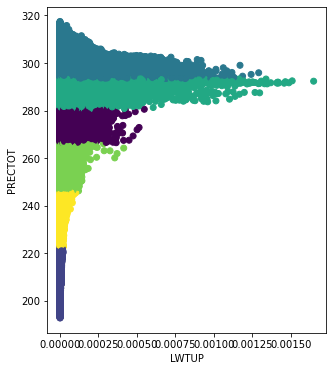

In [12]:
plt.figure(figsize=(5,6))
plt.scatter(x[0][:,[0]], x[0][:,[1]],c=kmeans.labels_)
plt.xlabel("LWTUP")
plt.ylabel("PRECTOT")
plt.show()
#plt.scatter(x[0][:,[0]], x[0][:,[2]],c=kmeans.labels_)
#plt.xlabel("LWTUP")
#plt.ylabel("TS")
#plt.show()
#plt.scatter(x[0][:,[1]], x[0][:,[2]],c=kmeans.labels_)
#plt.xlabel("PRECTOT")
#plt.ylabel("TS")
#plt.show()

est= [2 2 2 ... 0 0 3]


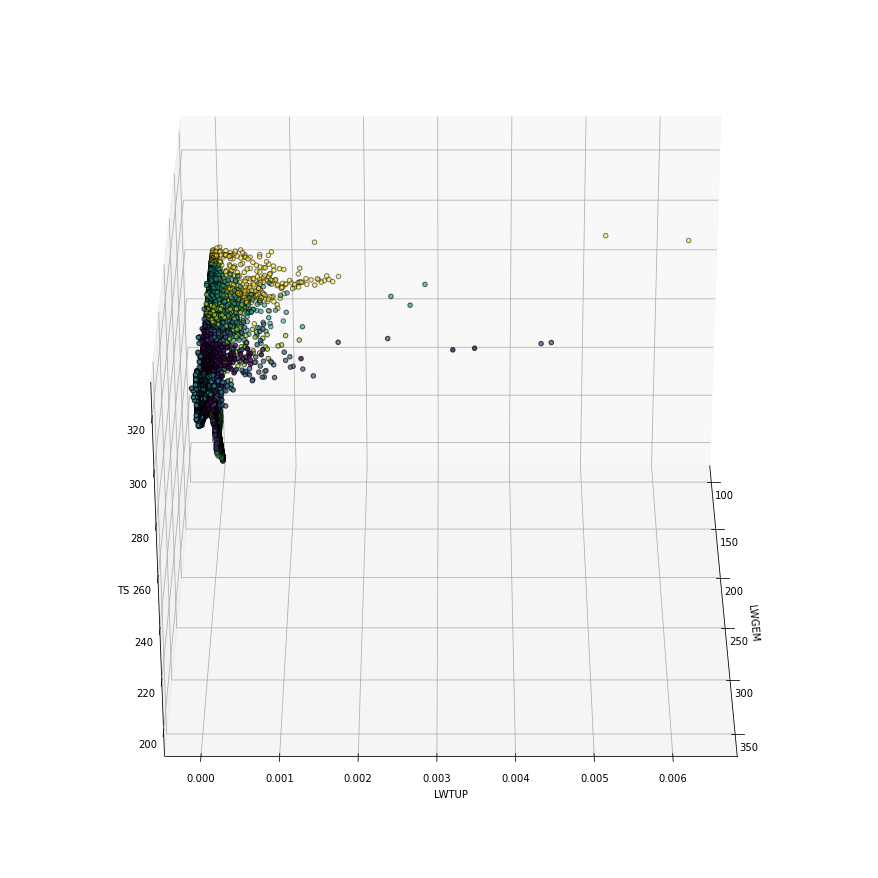

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
##matplotlib.use("agg")
fignum = 1
titles = ["8 clusters"]
estimators = [kmeans]
for est in estimators:
    fig = plt.figure(fignum, figsize=(16,12))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
    #est.fit(X)
    labels = est.labels_
    print ('est=', est.labels_)
    
    ax.scatter(x[0][:,[0]], x[0][:,[1]], x[0][:,[2]], c=est.labels_.astype(float), edgecolor="k")
#    ax.w_xaxis.set_ticklabels([])
#    ax.w_yaxis.set_ticklabels([])
#    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("LWGEM")
    ax.set_ylabel("LWTUP")
    ax.set_zlabel("TS")
#    ax.set_title(titles[fignum - 1])
#    ax.dist = 12
#    fignum = fignum + 1

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.1)